In [340]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from datetime import datetime

warnings.filterwarnings('ignore')

#模型预测
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


#降维
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from lightgbm.sklearn import LGBMRegressor

#评价
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.metrics import mean_absolute_error,make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [278]:
path = 'D:/data analysis/天池-二手车/'
train_data = pd.read_csv(path+'used_car_train_20200313.csv',sep=' ')
test_data = pd.read_csv(path+'used_car_testB_20200421.csv',sep= ' ')

In [280]:
train_data.shape

(150000, 31)

In [281]:
test_data.shape

(50000, 30)

In [282]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data.shape

(200000, 31)

In [283]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

In [284]:
all_data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              6010
fuelType             11604
gearbox               7949
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                50000
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [285]:
cat_fea = ['name','regDate','model','brand','bodyType','fuelType','gearbox','kilometer'
          ,'notRepairedDamage','regionCode','seller','offerType','creatDate']

In [289]:
for fea in cat_fea:
    print('{}特征有{}个不同的值'.format(fea,all_data[fea].nunique()))
    print(all_data[fea].value_counts())

name特征有128660个不同的值
387      376
55       373
708      367
1541     349
203      311
        ... 
45755      1
47802      1
53943      1
55990      1
4094       1
Name: name, Length: 128660, dtype: int64
regDate特征有3898个不同的值
20000008    235
20000011    213
20000002    211
20000009    206
20000001    205
           ... 
19910807      1
20151209      1
19910909      1
19910801      1
20151201      1
Name: regDate, Length: 3898, dtype: int64
model特征有248个不同的值
0.0      15534
19.0     12799
4.0      11235
1.0       8019
29.0      6964
         ...  
243.0        4
244.0        4
242.0        3
240.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand特征有40个不同的值
0     41953
4     22269
14    21434
10    18962
1     18421
6     13717
9      9666
5      6150
13     5203
11     3887
3      3281
7      3088
16     2993
25     2792
8      2785
27     2676
21     2090
15     1934
19     1861
20     1647
12     1508
22     1443
26     1294
30     1261
17     1225
24     1020
28      86

In [294]:
all_data['name_count'] = all_data.groupby(['name'])['SaleID'].transform('count')

In [297]:
del all_data['name']

In [304]:
all_data.drop(all_data[all_data['seller'] == 1].index,inplace=True)

In [305]:
all_data.shape

(199999, 31)

In [306]:
del all_data['offerType']
del all_data['seller']

In [308]:
all_data['fuelType'] = all_data['fuelType'].fillna(0)
all_data['gearbox'] = all_data['gearbox'].fillna(0)
all_data['bodyType'] = all_data['bodyType'].fillna(0)
all_data['model'] = all_data['model'].fillna(0)

In [314]:
all_data['notRepairedDamage'] = all_data['notRepairedDamage'].apply(lambda x: x if x != '-' else None).astype('float32')

In [321]:
cat_fea2 = ['model','brand','bodyType','fuelType','gearbox','kilometer'
          ,'notRepairedDamage','regionCode']

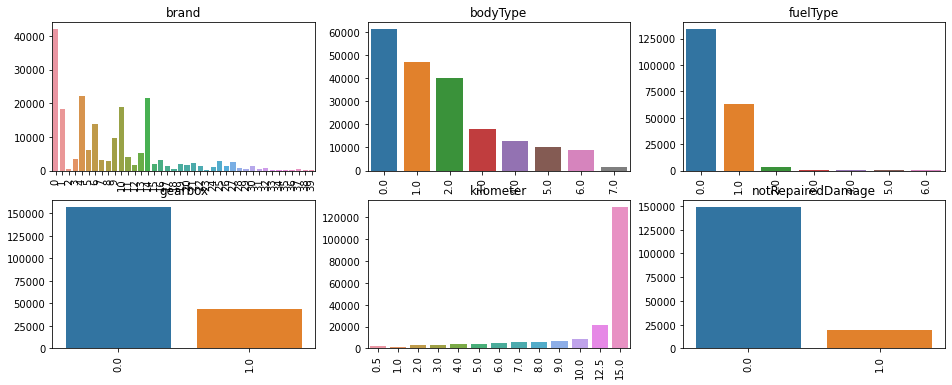

In [325]:
plt.figure(figsize=(16,6))
i = 1
for fea in cat_fea2:
    if all_data[fea].nunique()<50:
        plt.subplot(2,3,i)
        i += 1
        v = all_data[fea].value_counts()
        fig = sns.barplot(x=v.index,y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(fea)
plt.show()

In [326]:
num_fea = ['power','price','v_0','v_1','v_2','v_3','v_4','v_5',
           'v_6','v_7','v_8','v_9','v_10','v_11','v_12','v_13','v_14']

In [327]:
f = pd.melt(all_data,value_vars = num_fea)

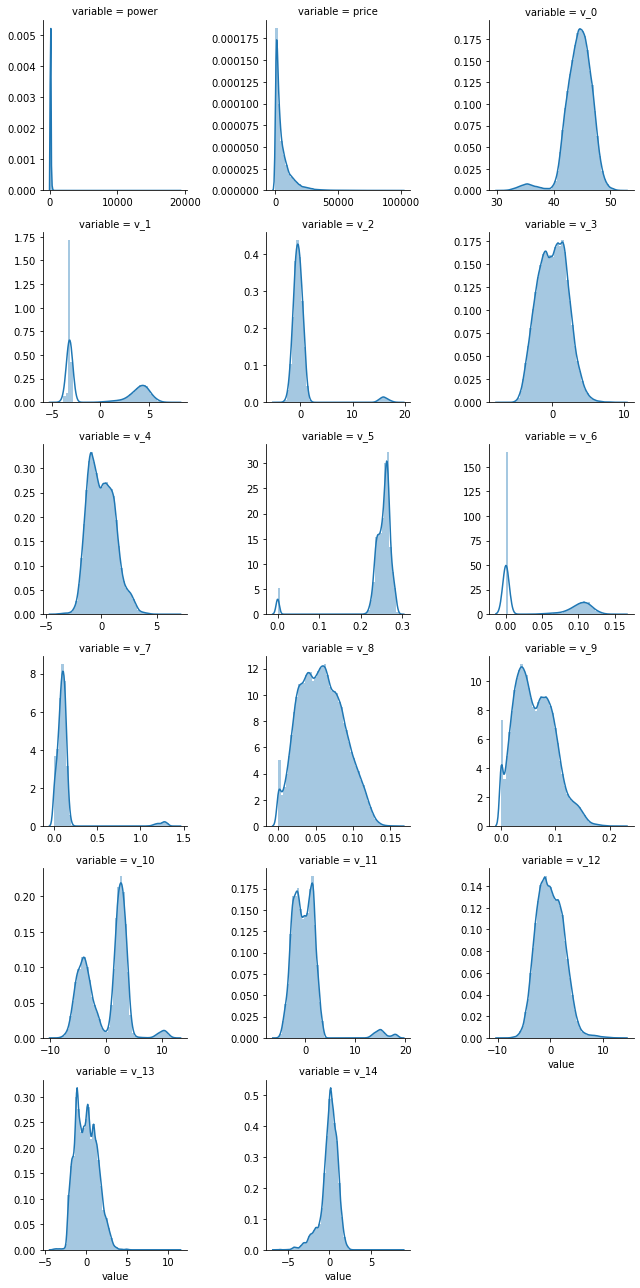

In [330]:
g = sns.FacetGrid(f,col="variable",col_wrap=3,sharex=False,sharey=False)
g = g.map(sns.distplot,'value')

In [333]:
all_data['power'] = all_data['power'].map(lambda x:600 if x>600 else x)

In [339]:
all_data['regDate']

0         20040402
1         20030301
2         20040403
3         19960908
4         20120103
            ...   
199995    20041005
199996    20130409
199997    20041211
199998    20020702
199999    20090708
Name: regDate, Length: 199999, dtype: int64

In [351]:
def date_process(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    
    if month < 1:
        month = 1
        
    date = datetime(year,month,day)
    return date

In [354]:
all_data['regDate'] = all_data['regDate'].apply(date_process)
all_data['creatDate'] = all_data['creatDate'].apply(date_process)

In [362]:
all_data['regDate_year'] = all_data['regDate'].dt.year
all_data['regDate_month'] = all_data['regDate'].dt.month
all_data['regDate_day'] = all_data['regDate'].dt.day
all_data['creatDate_year'] = all_data['creatDate'].dt.year
all_data['creatDate_month'] = all_data['creatDate'].dt.month
all_data['creatDate_day'] = all_data['creatDate'].dt.day
all_data['car_age_day'] = (all_data['creatDate'] - all_data['regDate']).dt.days

In [366]:
all_data['car_age_year'] = round(all_data['car_age_day'] / 365 , 1)

In [368]:
all_data['regionCode_count'] = all_data.groupby(['regionCode'])['SaleID'].transform('count')
all_data['city'] = all_data['regionCode'].apply(lambda x:str(x)[:2])

In [372]:
all_data.tail()

,SaleID,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,regDate_year,regDate_month,regDate_day,creatDate_year,creatDate_month,creatDate_day,car_age_day,car_age_year,regionCode_count,city
199995,249995,2004-10-05,4.0,4,0.0,0.0,1.0,150,15.0,NaN,...,2004,10,5,2016,3,9,4173,11.4,46,55
199996,249996,2013-04-09,65.0,1,0.0,0.0,0.0,179,4.0,0.0,...,2013,4,9,2016,3,23,1079,3.0,65,52
199997,249997,2004-12-11,4.0,4,0.0,0.0,1.0,147,12.5,0.0,...,2004,12,11,2016,3,16,4113,11.3,20,37
199998,249998,2002-07-02,40.0,1,4.0,0.0,1.0,176,15.0,0.0,...,2002,7,2,2016,3,27,5017,13.7,94,61
199999,249999,2009-07-08,32.0,8,1.0,0.0,0.0,0,3.0,0.0,...,2009,7,8,2016,4,1,2459,6.7,18,41


In [376]:
bin = [i*10 for i in range(31)]
all_data['power_bin'] = pd.cut(all_data['power'],bin,labels=False)

In [391]:
cat_cols = ['brand','model','kilometer','fuelType','bodyType']

In [392]:
for col in cat_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    all_data = pd.merge(all_data,t,on=col,how='left')

<AxesSubplot:>

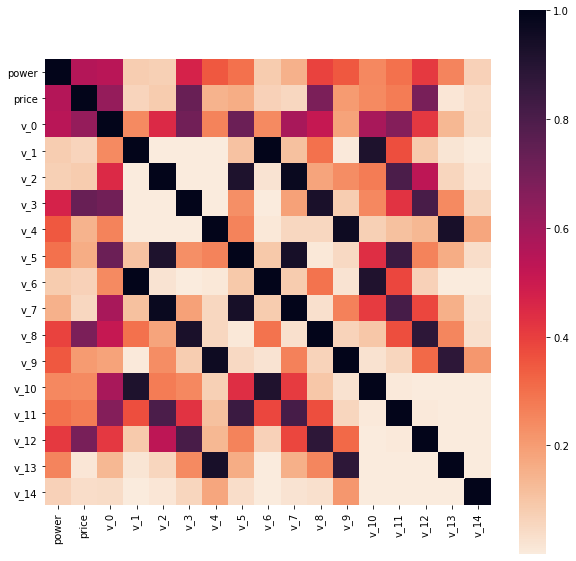

In [408]:
corr1 = abs(all_data[all_data['price'].notnull()][num_fea].corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr1,square=True,cmap=sns.cm.rocket_r)

In [409]:
#power,v0,v3,v8,v12

In [410]:
cross_cols = ['power','v_0','v_3','v_8','v_12']

In [411]:
for i in cross_cols:
    for j in cross_cols:
        all_data['new'+i+"*"+j] = all_data[i] * all_data[j]

(array([1.23906e+05, 1.89270e+04, 4.91800e+03, 1.34000e+03, 4.71000e+02,
        1.88000e+02, 1.24000e+02, 6.00000e+01, 4.80000e+01, 1.80000e+01]),
 array([1.10000e+01, 1.00098e+04, 2.00086e+04, 3.00074e+04, 4.00062e+04,
        5.00050e+04, 6.00038e+04, 7.00026e+04, 8.00014e+04, 9.00002e+04,
        9.99990e+04]),
 <BarContainer object of 10 artists>)

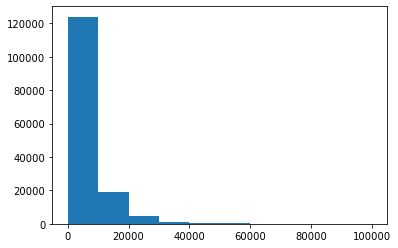

In [413]:
plt.hist(train_data['price'])

(array([   56.,   250.,  1548.,  6206., 22641., 36354., 39259., 31885.,
        10903.,   898.]),
 array([ 2.48490665,  3.38770853,  4.29051041,  5.19331229,  6.09611418,
         6.99891606,  7.90171794,  8.80451982,  9.7073217 , 10.61012358,
        11.51292546]),
 <BarContainer object of 10 artists>)

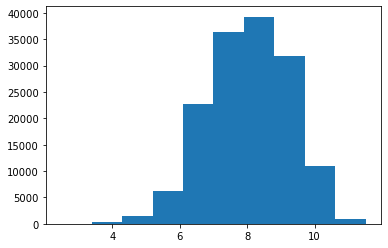

In [414]:
plt.hist(np.log1p(train_data['price']))

In [441]:
all_data['city'] = all_data['city'].astype('int')

In [442]:
df = all_data.copy()

In [443]:
test = df[df['price'].isnull()]
X_train = df[df['price'].notnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
X_test = df[df['price'].isnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
y_train = np.log1p(df[df['price'].notnull()]['price'])

In [446]:
y_train

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149994    8.682877
149995    9.159152
149996    8.922792
149997    8.517193
149998    8.455531
Name: price, Length: 149999, dtype: float64

In [423]:
X_train.shape

(149999, 130)

In [467]:
clf = LGBMRegressor(n_estimators=10000
                   ,learning_rate=0.2
                   ,boosting_type='gbdt'
                   ,objective='regression_l1'
                   ,max_depth=-1
                   ,num_leaves=30
                   ,min_child_samples=20
                   ,feature_fraction=0.8
                   ,lambda_l2=2 
                   ,metric='mae'
                   ,random_state=717)

In [468]:
folds = KFold(n_splits=5,shuffle=True,random_state=717)
mae = 0
oof = np.zeros(X_train.shape[0])
sub = test[['SaleID']].copy()
sub['price'] = 0

In [469]:
for i,(train_idx,val_idx) in enumerate(folds.split(X_train,y_train)):
    train_X,train_y = X_train.iloc[train_idx].reset_index(drop=True),y_train[train_idx]
    val_X,val_y = X_train.iloc[val_idx].reset_index(drop=True),y_train[val_idx]
    clf.fit(train_X,train_y
           ,eval_set=[(val_X,val_y)]
           ,eval_metric='mae'
           ,early_stopping_rounds=100
           ,verbose=0
           )
    sub['price'] = sub['price'] + np.expm1(clf.predict(X_test))/folds.n_splits
    oof[val_idx] = clf.predict(val_X)
    print('val_mae:',mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx])))
    mae = mae + mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx]))/folds.n_splits

val_mae: 512.2165022648489
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 508.0321471431761
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 526.1276459086737
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 506.09981558858465
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_

In [434]:
y_train

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149994    8.682877
149995    9.159152
149996    8.922792
149997    8.517193
149998    8.455531
Name: price, Length: 149999, dtype: float64

In [453]:
import hyperopt
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss

In [470]:
def hyperopt_objective(params):
    reg = LGBMRegressor(objective = 'regression_l1',
                        n_estimators = int(params['n_estimators']),
                        num_leaves = int(params['num_leaves']),
                        max_depth = int(params['max_depth']),
                        subsample = params['subsample'],
                        min_child_samples = int(params['min_child_samples'])   
                       )
    val = cross_val_score(reg,
                          X_train,
                          y_train,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error)
                         ).mean()
    return val

In [471]:
param_simple = {
                'n_estimators': hp.quniform('n_estimators',200,10000,1),
                'num_leaves': hp.quniform('num_leaves',2,100,1),
                'max_depth': hp.quniform('max_depth',2,100,1),
                'subsample': hp.uniform('subsample',0.1,1),
                'min_child_samples': hp.quniform('min_child_samples',2,100,1)
               }

In [472]:
def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    
    params_best = fmin(hyperopt_objective,
                       space = param_simple,
                       algo = tpe.suggest,
                       max_evals = max_evals,
                       verbose = True,
                       trials = trials,
                       early_stop_fn = early_stop_fn
                      )
    print('\n','\n','best params:',params_best,'\n')
    return params_best,trials

In [ ]:
params_best , trials = param_hyperopt(30)

 23%|██████████▎                                 | 7/30 [1:44:09<5:57:14, 931.92s/trial, best loss: 0.1130711638877095]

In [458]:
params_best

{'max_depth': 20.0,
 'min_child_samples': 91.0,
 'n_estimators': 100.0,
 'num_leaves': 98.0,
 'subsample': 0.651351675568202}

In [465]:
reg2 = LGBMRegressor(max_depth= 20,
                     min_child_samples= 91,
                     n_estimators= 100,
                     num_leaves= 98,
                     subsample= 0.651351675568202
                    ) 

In [466]:
reg2.fit(X_train,y_train)

LGBMRegressor(max_depth=20, min_child_samples=91, num_leaves=98,
              subsample=0.651351675568202)

In [257]:
def hyperopt_validation():
    reg = LGBMRegressor(objective = 'regression_l1',
                        n_estimators = int(100),
                        num_leaves = int(89),
                        max_depth = int(51),
                        subsample = float(0.7998695248344359),
                        min_child_samples = int(8)   
                       )
    val = cross_val_score(reg,
                          data_train_feature,
                          data_train_y,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error(data_train_y,))
                         ).mean()
    return val

In [227]:
np.expm1?

In [228]:
np.log1p?

In [236]:
data_train_yln = np.log1p(data_train_y)

In [237]:
def hyperopt_objective(params):
    reg = LGBMRegressor(objective = params['objective'],
                        n_estimators = int(params['n_estimators']),
                        num_leaves = int(params['num_leaves']),
                        max_depth = int(params['max_depth']),
                        subsample = params['subsample'],
                        min_child_samples = int(params['min_child_samples'])   
                       )
    val = cross_val_score(reg,
                          data_train,
                          data_train_yln,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error)
                         ).mean()
    return val

(array([   56.,   222.,  1505.,  6219., 22287., 35342., 39020., 33043.,
        10694.,   649.]),
 array([ 2.39789527,  3.30939729,  4.22089931,  5.13240133,  6.04390335,
         6.95540537,  7.86690739,  8.77840941,  9.68991143, 10.60141345,
        11.51291546]),
 <BarContainer object of 10 artists>)

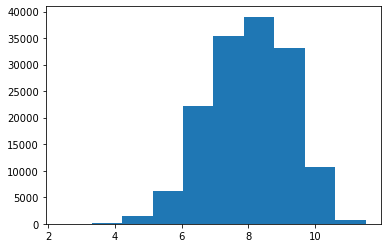

In [219]:
plt.hist(np.log(data['price']))

(array([1.99018e+05, 6.00000e+00, 1.00000e+00, 2.00000e+00, 2.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([    0. ,  1921.1,  3842.2,  5763.3,  7684.4,  9605.5, 11526.6,
        13447.7, 15368.8, 17289.9, 19211. ]),
 <BarContainer object of 10 artists>)

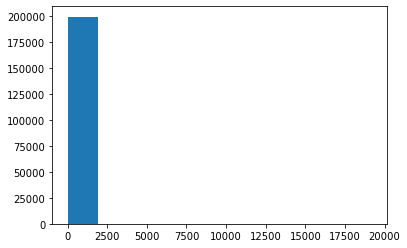

In [220]:
plt.hist(data['power'])

(array([13011., 21713., 42438., 32541., 22433.,  8725.,  4261.,  1815.,
         1493.,   607.]),
 array([  0. ,  37.5,  75. , 112.5, 150. , 187.5, 225. , 262.5, 300. ,
        337.5, 375. ]),
 <BarContainer object of 10 artists>)

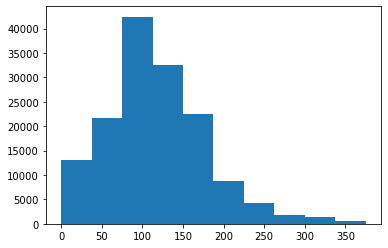

In [222]:
plt.hist(data_train['power'])

In [217]:
data[data['price'] > 20000]['price']

155       34900.0
162       66666.0
171       23000.0
185       24490.0
274       29900.0
           ...   
148953    22950.0
148963    37999.0
148965    34500.0
148969    28950.0
149028    24950.0
Name: price, Length: 6565, dtype: float64

In [224]:
data['power_bin'].value_counts()

10.0    24026
7.0     17565
13.0    16008
5.0     15351
14.0    14228
11.0    12986
8.0     11884
16.0    10856
12.0     9190
6.0      7360
17.0     5458
19.0     4586
4.0      4492
9.0      4153
23.0     3174
18.0     3115
15.0     2889
21.0     2683
20.0     1974
22.0     1841
24.0     1418
27.0     1052
25.0      597
28.0      551
26.0      506
29.0      488
3.0       288
0.0       113
1.0        55
2.0        24
Name: power_bin, dtype: int64

In [199]:
data['notRepairedDamage'].replace('-',np.nan,inplace=True)

In [202]:
data['notRepairedDamage'] = data['notRepairedDamage'].astype(float)

In [203]:
data_train = data[data['SaleID'] <150000]

In [204]:
data_train.shape

(149037, 39)

In [205]:
data_train_y = data_train['price']

In [206]:
data_train.drop(['price'],axis=1,inplace=True)

In [207]:
data_train.shape

(149037, 38)

In [208]:
data_test = data[data['SaleID']>=150000]
data_test.shape

(50000, 39)

In [209]:
data_test.drop(['price'],axis=1,inplace=True)

In [210]:
data_test.shape

(50000, 38)

In [211]:
data_train

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,...,4385.0,1.0,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37,5.0
1,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,NaN,...,4757.0,4.0,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86,NaN
2,2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,...,4382.0,2.0,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83,16.0
3,3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,...,7125.0,NaN,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76,19.0
4,4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,...,1531.0,6.0,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149032,149995,163978,121.0,10,4.0,0.0,1.0,163,15.0,0.0,...,5772.0,4.0,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76,16.0
149033,149996,184535,116.0,11,0.0,0.0,0.0,125,10.0,0.0,...,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4722.160492,4549.41,12.0
149034,149997,147587,60.0,11,1.0,1.0,0.0,90,6.0,0.0,...,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4722.160492,4549.41,8.0
149035,149998,45907,34.0,10,3.0,1.0,0.0,156,15.0,0.0,...,3673.0,1.0,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76,15.0


In [212]:
model = LGBMRegressor(n_estimators=100,objective='regression_l1')
score = np.mean(cross_val_score(model,X = data_train, y = data_train_y,cv=5,scoring=make_scorer(mean_absolute_error)))

In [213]:
score

694.871349990319

In [145]:
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators=150)
    param_grid={
        'learning_rate':[0.01,0.05,0.1,0.2],
    }
    gbm = GridSearchCV(estimator,param_grid)
    gbm.fit(x_train,y_train)
    return gbm

In [146]:
x_train,x_val,y_train,y_val = train_test_split(data_train,data_train_y,test_size=0.3)

In [147]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

Train lgb...
MAE of val with lgb: 576.221437889809


In [150]:
import hyperopt
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss

In [159]:
def hyperopt_objective(params):
    reg = LGBMRegressor(objective = params['objective'],
                        n_estimators = int(params['n_estimators']),
                        num_leaves = int(params['num_leaves']),
                        max_depth = int(params['max_depth']),
                        subsample = params['subsample'],
                        min_child_samples = int(params['min_child_samples'])   
                       )
    val = cross_val_score(reg,
                          data_train,
                          data_train_y,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error)
                         ).mean()
    return val

In [160]:
param_simple = {'objective': hp.choice('objective',['regression_l1','regression','huber','fair','mape']),
                'n_estimators': hp.quniform('n_estimators',2,100,1),
                'num_leaves': hp.quniform('num_leaves',2,100,1),
                'max_depth': hp.quniform('max_depth',2,100,1),
                'subsample': hp.uniform('subsample',0.1,1),
                'min_child_samples': hp.quniform('min_child_samples',2,100,1)
               }

In [161]:
def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    
    params_best = fmin(hyperopt_objective,
                       space = param_simple,
                       algo = tpe.suggest,
                       max_evals = max_evals,
                       verbose = True,
                       trials = trials,
                       early_stop_fn = early_stop_fn
                      )
    print('\n','\n','best params:',params_best,'\n')
    return params_best,trials

In [162]:
params_best , trials = param_hyperopt(30)

100%|█████████████████████████████████████████████████| 30/30 [03:44<00:00,  7.48s/trial, best loss: 600.2664210542868]

 
 best params: {'max_depth': 28.0, 'min_child_samples': 17.0, 'n_estimators': 98.0, 'num_leaves': 100.0, 'objective': 1, 'subsample': 0.9778016942428467} 



In [227]:
np.expm1?

In [228]:
np.log1p?

In [236]:
data_train_yln = np.log1p(data_train_y)

In [237]:
def hyperopt_objective(params):
    reg = LGBMRegressor(objective = params['objective'],
                        n_estimators = int(params['n_estimators']),
                        num_leaves = int(params['num_leaves']),
                        max_depth = int(params['max_depth']),
                        subsample = params['subsample'],
                        min_child_samples = int(params['min_child_samples'])   
                       )
    val = cross_val_score(reg,
                          data_train,
                          data_train_yln,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error)
                         ).mean()
    return val

In [238]:
param_simple = {'objective': hp.choice('objective',['regression_l1','regression','huber','fair','mape']),
                'n_estimators': hp.quniform('n_estimators',2,100,1),
                'num_leaves': hp.quniform('num_leaves',2,100,1),
                'max_depth': hp.quniform('max_depth',2,100,1),
                'subsample': hp.uniform('subsample',0.1,1),
                'min_child_samples': hp.quniform('min_child_samples',2,100,1)
               }

In [239]:
def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    
    params_best = fmin(hyperopt_objective,
                       space = param_simple,
                       algo = tpe.suggest,
                       max_evals = max_evals,
                       verbose = True,
                       trials = trials,
                       early_stop_fn = early_stop_fn
                      )
    print('\n','\n','best params:',params_best,'\n')
    return params_best,trials

In [240]:
params_best , trials = param_hyperopt(30)

100%|███████████████████████████████████████████████| 30/30 [04:23<00:00,  8.77s/trial, best loss: 0.13536712444098167]

 
 best params: {'max_depth': 51.0, 'min_child_samples': 8.0, 'n_estimators': 100.0, 'num_leaves': 89.0, 'objective': 0, 'subsample': 0.7998695248344359} 



In [244]:
len(trials.losses())

30

In [256]:
data_train_feature = data_train.drop('SaleID',axis=1)

In [257]:
def hyperopt_validation():
    reg = LGBMRegressor(objective = 'regression_l1',
                        n_estimators = int(100),
                        num_leaves = int(89),
                        max_depth = int(51),
                        subsample = float(0.7998695248344359),
                        min_child_samples = int(8)   
                       )
    val = cross_val_score(reg,
                          data_train_feature,
                          data_train_y,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error(data_train_y,))
                         ).mean()
    return val

In [264]:
from sklearn.model_selection import KFold

In [265]:
skf = KFold(n_splits=5,shuffle=True,random_state=717)

In [276]:
clf = LGBMRegressor(objective = 'regression_l1',
                        n_estimators = 2500,
                        num_leaves = int(89),
                        max_depth = int(51),
                        subsample = float(0.7998695248344359),
                        min_child_samples = 10
                   )

In [266]:
data_test

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
149037,200000,133777,67.0,0,1.0,0.0,0.0,101,15.0,0.0,...,5790.0,5.0,31429.0,68500.0,3199.0,13.0,173719698.0,6261.371627,5527.19,10.0
149038,200001,61206,19.0,6,2.0,0.0,0.0,73,6.0,0.0,...,7698.0,1.0,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37,7.0
149039,200002,67829,5.0,5,4.0,0.0,0.0,120,5.0,NaN,...,2468.0,1.0,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67,11.0
149040,200003,8892,22.0,9,1.0,0.0,0.0,58,15.0,0.0,...,5035.0,NaN,7299.0,68530.0,1400.0,50.0,17805271.0,2975.342884,2439.08,5.0
149041,200004,76998,46.0,6,0.0,NaN,0.0,116,15.0,0.0,...,4754.0,NaN,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,249995,111443,4.0,4,0.0,NaN,1.0,150,15.0,NaN,...,4173.0,5.0,16575.0,99999.0,5999.0,12.0,138279069.0,8089.863295,8342.13,14.0
199033,249996,152834,65.0,1,0.0,0.0,0.0,179,4.0,0.0,...,1079.0,5.0,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86,17.0
199034,249997,132531,4.0,4,0.0,0.0,1.0,147,12.5,0.0,...,4113.0,3.0,16575.0,99999.0,5999.0,12.0,138279069.0,8089.863295,8342.13,14.0
199035,249998,143405,40.0,1,4.0,0.0,1.0,176,15.0,0.0,...,5017.0,NaN,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86,17.0


In [269]:
oof = np.zeros(data_train.shape[0])
mae = 0

In [272]:
data_train_yln

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149032    8.682877
149033    9.159152
149034    8.922792
149035    8.517193
149036    8.455531
Name: price, Length: 149037, dtype: float64

In [277]:
for i , (train_idx,val_idx) in enumerate(skf.split(data_train_feature,data_train_yln)):
    train_x , train_y = data_train.iloc[train_idx].reset_index(drop=True),data_train_yln[train_idx]
    val_x ,val_y = data_train.iloc[val_idx].reset_index(drop=True),data_train_yln[val_idx]
    clf.fit(train_x,train_y,
            eval_set=[(val_x,val_y)],
            eval_metric = 'mae',
            early_stopping_rounds=100,
            )
    oof[val_idx] = clf.predict(val_x)
    print('val mae:',mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx])))
    mae = mae + mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx]))/skf.n_splits

[1]	valid_0's l1: 0.903561
[2]	valid_0's l1: 0.827598
[3]	valid_0's l1: 0.760324
[4]	valid_0's l1: 0.699054
[5]	valid_0's l1: 0.643534
[6]	valid_0's l1: 0.595581
[7]	valid_0's l1: 0.551929
[8]	valid_0's l1: 0.51194
[9]	valid_0's l1: 0.476855
[10]	valid_0's l1: 0.444828
[11]	valid_0's l1: 0.416053
[12]	valid_0's l1: 0.389942
[13]	valid_0's l1: 0.366686
[14]	valid_0's l1: 0.346022
[15]	valid_0's l1: 0.326888
[16]	valid_0's l1: 0.309912
[17]	valid_0's l1: 0.295088
[18]	valid_0's l1: 0.281571
[19]	valid_0's l1: 0.269709
[20]	valid_0's l1: 0.258986
[21]	valid_0's l1: 0.248932
[22]	valid_0's l1: 0.239827
[23]	valid_0's l1: 0.231746
[24]	valid_0's l1: 0.224524
[25]	valid_0's l1: 0.217996
[26]	valid_0's l1: 0.211944
[27]	valid_0's l1: 0.206535
[28]	valid_0's l1: 0.201512
[29]	valid_0's l1: 0.196869
[30]	valid_0's l1: 0.192696
[31]	valid_0's l1: 0.188728
[32]	valid_0's l1: 0.185151
[33]	valid_0's l1: 0.182216
[34]	valid_0's l1: 0.179105
[35]	valid_0's l1: 0.176409
[36]	valid_0's l1: 0.17399
[37

[292]	valid_0's l1: 0.127482
[293]	valid_0's l1: 0.127473
[294]	valid_0's l1: 0.127386
[295]	valid_0's l1: 0.127351
[296]	valid_0's l1: 0.127324
[297]	valid_0's l1: 0.127316
[298]	valid_0's l1: 0.127282
[299]	valid_0's l1: 0.127259
[300]	valid_0's l1: 0.127235
[301]	valid_0's l1: 0.127217
[302]	valid_0's l1: 0.127187
[303]	valid_0's l1: 0.127172
[304]	valid_0's l1: 0.127145
[305]	valid_0's l1: 0.127121
[306]	valid_0's l1: 0.127115
[307]	valid_0's l1: 0.12709
[308]	valid_0's l1: 0.127075
[309]	valid_0's l1: 0.127066
[310]	valid_0's l1: 0.12704
[311]	valid_0's l1: 0.127018
[312]	valid_0's l1: 0.126999
[313]	valid_0's l1: 0.12698
[314]	valid_0's l1: 0.126954
[315]	valid_0's l1: 0.126945
[316]	valid_0's l1: 0.126922
[317]	valid_0's l1: 0.126912
[318]	valid_0's l1: 0.126907
[319]	valid_0's l1: 0.126904
[320]	valid_0's l1: 0.126887
[321]	valid_0's l1: 0.126871
[322]	valid_0's l1: 0.126858
[323]	valid_0's l1: 0.126799
[324]	valid_0's l1: 0.126793
[325]	valid_0's l1: 0.126786
[326]	valid_0's l

[579]	valid_0's l1: 0.12453
[580]	valid_0's l1: 0.124528
[581]	valid_0's l1: 0.124526
[582]	valid_0's l1: 0.124524
[583]	valid_0's l1: 0.124523
[584]	valid_0's l1: 0.124521
[585]	valid_0's l1: 0.12452
[586]	valid_0's l1: 0.124517
[587]	valid_0's l1: 0.124512
[588]	valid_0's l1: 0.12451
[589]	valid_0's l1: 0.124509
[590]	valid_0's l1: 0.124508
[591]	valid_0's l1: 0.124503
[592]	valid_0's l1: 0.124502
[593]	valid_0's l1: 0.124503
[594]	valid_0's l1: 0.124502
[595]	valid_0's l1: 0.124503
[596]	valid_0's l1: 0.124506
[597]	valid_0's l1: 0.124505
[598]	valid_0's l1: 0.124505
[599]	valid_0's l1: 0.124504
[600]	valid_0's l1: 0.124503
[601]	valid_0's l1: 0.124503
[602]	valid_0's l1: 0.124503
[603]	valid_0's l1: 0.124496
[604]	valid_0's l1: 0.124494
[605]	valid_0's l1: 0.124491
[606]	valid_0's l1: 0.124491
[607]	valid_0's l1: 0.124489
[608]	valid_0's l1: 0.124489
[609]	valid_0's l1: 0.124487
[610]	valid_0's l1: 0.124487
[611]	valid_0's l1: 0.124487
[612]	valid_0's l1: 0.124487
[613]	valid_0's l

[863]	valid_0's l1: 0.12389
[864]	valid_0's l1: 0.123885
[865]	valid_0's l1: 0.123887
[866]	valid_0's l1: 0.123882
[867]	valid_0's l1: 0.123882
[868]	valid_0's l1: 0.123881
[869]	valid_0's l1: 0.123881
[870]	valid_0's l1: 0.123878
[871]	valid_0's l1: 0.123878
[872]	valid_0's l1: 0.123878
[873]	valid_0's l1: 0.123877
[874]	valid_0's l1: 0.123877
[875]	valid_0's l1: 0.123877
[876]	valid_0's l1: 0.123877
[877]	valid_0's l1: 0.12387
[878]	valid_0's l1: 0.123872
[879]	valid_0's l1: 0.123871
[880]	valid_0's l1: 0.123871
[881]	valid_0's l1: 0.12387
[882]	valid_0's l1: 0.12387
[883]	valid_0's l1: 0.123869
[884]	valid_0's l1: 0.123867
[885]	valid_0's l1: 0.123866
[886]	valid_0's l1: 0.123867
[887]	valid_0's l1: 0.123858
[888]	valid_0's l1: 0.123859
[889]	valid_0's l1: 0.123857
[890]	valid_0's l1: 0.123853
[891]	valid_0's l1: 0.12385
[892]	valid_0's l1: 0.123848
[893]	valid_0's l1: 0.123854
[894]	valid_0's l1: 0.123849
[895]	valid_0's l1: 0.123848
[896]	valid_0's l1: 0.123846
[897]	valid_0's l1:

[1148]	valid_0's l1: 0.123538
[1149]	valid_0's l1: 0.123538
[1150]	valid_0's l1: 0.123537
[1151]	valid_0's l1: 0.123536
[1152]	valid_0's l1: 0.123536
[1153]	valid_0's l1: 0.123536
[1154]	valid_0's l1: 0.123536
[1155]	valid_0's l1: 0.123533
[1156]	valid_0's l1: 0.123532
[1157]	valid_0's l1: 0.123532
[1158]	valid_0's l1: 0.12353
[1159]	valid_0's l1: 0.12353
[1160]	valid_0's l1: 0.12353
[1161]	valid_0's l1: 0.123529
[1162]	valid_0's l1: 0.123529
[1163]	valid_0's l1: 0.123529
[1164]	valid_0's l1: 0.123528
[1165]	valid_0's l1: 0.123529
[1166]	valid_0's l1: 0.123529
[1167]	valid_0's l1: 0.123529
[1168]	valid_0's l1: 0.123528
[1169]	valid_0's l1: 0.123529
[1170]	valid_0's l1: 0.123529
[1171]	valid_0's l1: 0.123528
[1172]	valid_0's l1: 0.123525
[1173]	valid_0's l1: 0.12352
[1174]	valid_0's l1: 0.12352
[1175]	valid_0's l1: 0.123519
[1176]	valid_0's l1: 0.123516
[1177]	valid_0's l1: 0.123515
[1178]	valid_0's l1: 0.123514
[1179]	valid_0's l1: 0.123514
[1180]	valid_0's l1: 0.123513
[1181]	valid_0'

[1427]	valid_0's l1: 0.123365
[1428]	valid_0's l1: 0.123368
[1429]	valid_0's l1: 0.123368
[1430]	valid_0's l1: 0.123368
[1431]	valid_0's l1: 0.123368
[1432]	valid_0's l1: 0.123369
[1433]	valid_0's l1: 0.123368
[1434]	valid_0's l1: 0.12337
[1435]	valid_0's l1: 0.123365
[1436]	valid_0's l1: 0.123364
[1437]	valid_0's l1: 0.123363
[1438]	valid_0's l1: 0.123362
[1439]	valid_0's l1: 0.12336
[1440]	valid_0's l1: 0.12336
[1441]	valid_0's l1: 0.123363
[1442]	valid_0's l1: 0.123359
[1443]	valid_0's l1: 0.123354
[1444]	valid_0's l1: 0.123345
[1445]	valid_0's l1: 0.123345
[1446]	valid_0's l1: 0.123342
[1447]	valid_0's l1: 0.123343
[1448]	valid_0's l1: 0.12333
[1449]	valid_0's l1: 0.12333
[1450]	valid_0's l1: 0.123339
[1451]	valid_0's l1: 0.123339
[1452]	valid_0's l1: 0.123339
[1453]	valid_0's l1: 0.123334
[1454]	valid_0's l1: 0.123326
[1455]	valid_0's l1: 0.123327
[1456]	valid_0's l1: 0.123329
[1457]	valid_0's l1: 0.123328
[1458]	valid_0's l1: 0.123329
[1459]	valid_0's l1: 0.123328
[1460]	valid_0'

[1705]	valid_0's l1: 0.123193
[1706]	valid_0's l1: 0.123193
[1707]	valid_0's l1: 0.123193
[1708]	valid_0's l1: 0.123193
[1709]	valid_0's l1: 0.123193
[1710]	valid_0's l1: 0.123193
[1711]	valid_0's l1: 0.123189
[1712]	valid_0's l1: 0.123188
[1713]	valid_0's l1: 0.123188
[1714]	valid_0's l1: 0.123189
[1715]	valid_0's l1: 0.123189
[1716]	valid_0's l1: 0.123189
[1717]	valid_0's l1: 0.123189
[1718]	valid_0's l1: 0.123189
[1719]	valid_0's l1: 0.123189
[1720]	valid_0's l1: 0.123189
[1721]	valid_0's l1: 0.123189
[1722]	valid_0's l1: 0.123189
[1723]	valid_0's l1: 0.123183
[1724]	valid_0's l1: 0.123183
[1725]	valid_0's l1: 0.123183
[1726]	valid_0's l1: 0.123183
[1727]	valid_0's l1: 0.123183
[1728]	valid_0's l1: 0.123183
[1729]	valid_0's l1: 0.123174
[1730]	valid_0's l1: 0.123174
[1731]	valid_0's l1: 0.123174
[1732]	valid_0's l1: 0.123172
[1733]	valid_0's l1: 0.123172
[1734]	valid_0's l1: 0.123173
[1735]	valid_0's l1: 0.123172
[1736]	valid_0's l1: 0.123166
[1737]	valid_0's l1: 0.123166
[1738]	val

[1990]	valid_0's l1: 0.122856
[1991]	valid_0's l1: 0.122854
[1992]	valid_0's l1: 0.122853
[1993]	valid_0's l1: 0.122852
[1994]	valid_0's l1: 0.122852
[1995]	valid_0's l1: 0.122853
[1996]	valid_0's l1: 0.122852
[1997]	valid_0's l1: 0.122849
[1998]	valid_0's l1: 0.122839
[1999]	valid_0's l1: 0.122839
[2000]	valid_0's l1: 0.122839
[2001]	valid_0's l1: 0.122839
[2002]	valid_0's l1: 0.122839
[2003]	valid_0's l1: 0.122839
[2004]	valid_0's l1: 0.122839
[2005]	valid_0's l1: 0.122839
[2006]	valid_0's l1: 0.122839
[2007]	valid_0's l1: 0.122839
[2008]	valid_0's l1: 0.122839
[2009]	valid_0's l1: 0.122839
[2010]	valid_0's l1: 0.122839
[2011]	valid_0's l1: 0.122839
[2012]	valid_0's l1: 0.122839
[2013]	valid_0's l1: 0.122839
[2014]	valid_0's l1: 0.122839
[2015]	valid_0's l1: 0.122838
[2016]	valid_0's l1: 0.122838
[2017]	valid_0's l1: 0.122838
[2018]	valid_0's l1: 0.122838
[2019]	valid_0's l1: 0.122838
[2020]	valid_0's l1: 0.122838
[2021]	valid_0's l1: 0.122838
[2022]	valid_0's l1: 0.122838
[2023]	val

[2268]	valid_0's l1: 0.122637
[2269]	valid_0's l1: 0.122634
[2270]	valid_0's l1: 0.122634
[2271]	valid_0's l1: 0.122631
[2272]	valid_0's l1: 0.12263
[2273]	valid_0's l1: 0.12263
[2274]	valid_0's l1: 0.122631
[2275]	valid_0's l1: 0.122631
[2276]	valid_0's l1: 0.122631
[2277]	valid_0's l1: 0.122633
[2278]	valid_0's l1: 0.122634
[2279]	valid_0's l1: 0.122634
[2280]	valid_0's l1: 0.122635
[2281]	valid_0's l1: 0.122636
[2282]	valid_0's l1: 0.122633
[2283]	valid_0's l1: 0.122632
[2284]	valid_0's l1: 0.12263
[2285]	valid_0's l1: 0.122628
[2286]	valid_0's l1: 0.122625
[2287]	valid_0's l1: 0.122624
[2288]	valid_0's l1: 0.122623
[2289]	valid_0's l1: 0.122621
[2290]	valid_0's l1: 0.122623
[2291]	valid_0's l1: 0.122623
[2292]	valid_0's l1: 0.122623
[2293]	valid_0's l1: 0.122623
[2294]	valid_0's l1: 0.122619
[2295]	valid_0's l1: 0.122618
[2296]	valid_0's l1: 0.122619
[2297]	valid_0's l1: 0.122619
[2298]	valid_0's l1: 0.122617
[2299]	valid_0's l1: 0.122615
[2300]	valid_0's l1: 0.122615
[2301]	valid_

[55]	valid_0's l1: 0.14776
[56]	valid_0's l1: 0.147218
[57]	valid_0's l1: 0.146584
[58]	valid_0's l1: 0.146032
[59]	valid_0's l1: 0.145538
[60]	valid_0's l1: 0.144976
[61]	valid_0's l1: 0.144539
[62]	valid_0's l1: 0.144143
[63]	valid_0's l1: 0.143581
[64]	valid_0's l1: 0.143231
[65]	valid_0's l1: 0.142972
[66]	valid_0's l1: 0.14266
[67]	valid_0's l1: 0.142307
[68]	valid_0's l1: 0.141958
[69]	valid_0's l1: 0.141692
[70]	valid_0's l1: 0.141451
[71]	valid_0's l1: 0.141095
[72]	valid_0's l1: 0.140838
[73]	valid_0's l1: 0.140595
[74]	valid_0's l1: 0.140294
[75]	valid_0's l1: 0.140068
[76]	valid_0's l1: 0.139788
[77]	valid_0's l1: 0.139516
[78]	valid_0's l1: 0.139241
[79]	valid_0's l1: 0.13903
[80]	valid_0's l1: 0.138683
[81]	valid_0's l1: 0.138438
[82]	valid_0's l1: 0.138144
[83]	valid_0's l1: 0.137979
[84]	valid_0's l1: 0.137853
[85]	valid_0's l1: 0.137671
[86]	valid_0's l1: 0.137507
[87]	valid_0's l1: 0.137344
[88]	valid_0's l1: 0.137154
[89]	valid_0's l1: 0.136983
[90]	valid_0's l1: 0.13

[342]	valid_0's l1: 0.124635
[343]	valid_0's l1: 0.124628
[344]	valid_0's l1: 0.12462
[345]	valid_0's l1: 0.124604
[346]	valid_0's l1: 0.124589
[347]	valid_0's l1: 0.124588
[348]	valid_0's l1: 0.124584
[349]	valid_0's l1: 0.124573
[350]	valid_0's l1: 0.124573
[351]	valid_0's l1: 0.124572
[352]	valid_0's l1: 0.124571
[353]	valid_0's l1: 0.124569
[354]	valid_0's l1: 0.124568
[355]	valid_0's l1: 0.124567
[356]	valid_0's l1: 0.12457
[357]	valid_0's l1: 0.124563
[358]	valid_0's l1: 0.124564
[359]	valid_0's l1: 0.124562
[360]	valid_0's l1: 0.124529
[361]	valid_0's l1: 0.124504
[362]	valid_0's l1: 0.124501
[363]	valid_0's l1: 0.124497
[364]	valid_0's l1: 0.124497
[365]	valid_0's l1: 0.124495
[366]	valid_0's l1: 0.124495
[367]	valid_0's l1: 0.12449
[368]	valid_0's l1: 0.124482
[369]	valid_0's l1: 0.124483
[370]	valid_0's l1: 0.124461
[371]	valid_0's l1: 0.124446
[372]	valid_0's l1: 0.124438
[373]	valid_0's l1: 0.124432
[374]	valid_0's l1: 0.124413
[375]	valid_0's l1: 0.12441
[376]	valid_0's l1

[635]	valid_0's l1: 0.122434
[636]	valid_0's l1: 0.122431
[637]	valid_0's l1: 0.122417
[638]	valid_0's l1: 0.122412
[639]	valid_0's l1: 0.122409
[640]	valid_0's l1: 0.122408
[641]	valid_0's l1: 0.122404
[642]	valid_0's l1: 0.122401
[643]	valid_0's l1: 0.122399
[644]	valid_0's l1: 0.122393
[645]	valid_0's l1: 0.122394
[646]	valid_0's l1: 0.122386
[647]	valid_0's l1: 0.12238
[648]	valid_0's l1: 0.122367
[649]	valid_0's l1: 0.12236
[650]	valid_0's l1: 0.122361
[651]	valid_0's l1: 0.122359
[652]	valid_0's l1: 0.122353
[653]	valid_0's l1: 0.122347
[654]	valid_0's l1: 0.122347
[655]	valid_0's l1: 0.122346
[656]	valid_0's l1: 0.122347
[657]	valid_0's l1: 0.122342
[658]	valid_0's l1: 0.122343
[659]	valid_0's l1: 0.122342
[660]	valid_0's l1: 0.122342
[661]	valid_0's l1: 0.122341
[662]	valid_0's l1: 0.122342
[663]	valid_0's l1: 0.122344
[664]	valid_0's l1: 0.122344
[665]	valid_0's l1: 0.122335
[666]	valid_0's l1: 0.122315
[667]	valid_0's l1: 0.122311
[668]	valid_0's l1: 0.122307
[669]	valid_0's 

[928]	valid_0's l1: 0.121589
[929]	valid_0's l1: 0.121588
[930]	valid_0's l1: 0.121588
[931]	valid_0's l1: 0.121588
[932]	valid_0's l1: 0.121588
[933]	valid_0's l1: 0.121589
[934]	valid_0's l1: 0.121588
[935]	valid_0's l1: 0.121588
[936]	valid_0's l1: 0.121589
[937]	valid_0's l1: 0.121582
[938]	valid_0's l1: 0.121578
[939]	valid_0's l1: 0.121579
[940]	valid_0's l1: 0.121579
[941]	valid_0's l1: 0.121577
[942]	valid_0's l1: 0.121575
[943]	valid_0's l1: 0.121575
[944]	valid_0's l1: 0.121575
[945]	valid_0's l1: 0.121574
[946]	valid_0's l1: 0.121574
[947]	valid_0's l1: 0.121574
[948]	valid_0's l1: 0.121574
[949]	valid_0's l1: 0.121574
[950]	valid_0's l1: 0.121574
[951]	valid_0's l1: 0.121574
[952]	valid_0's l1: 0.121575
[953]	valid_0's l1: 0.121568
[954]	valid_0's l1: 0.121566
[955]	valid_0's l1: 0.121565
[956]	valid_0's l1: 0.12154
[957]	valid_0's l1: 0.121538
[958]	valid_0's l1: 0.121539
[959]	valid_0's l1: 0.121536
[960]	valid_0's l1: 0.121535
[961]	valid_0's l1: 0.121531
[962]	valid_0's

[1206]	valid_0's l1: 0.121122
[1207]	valid_0's l1: 0.121121
[1208]	valid_0's l1: 0.121122
[1209]	valid_0's l1: 0.121118
[1210]	valid_0's l1: 0.121116
[1211]	valid_0's l1: 0.121116
[1212]	valid_0's l1: 0.121109
[1213]	valid_0's l1: 0.121108
[1214]	valid_0's l1: 0.121101
[1215]	valid_0's l1: 0.121097
[1216]	valid_0's l1: 0.121095
[1217]	valid_0's l1: 0.121092
[1218]	valid_0's l1: 0.121096
[1219]	valid_0's l1: 0.121096
[1220]	valid_0's l1: 0.121098
[1221]	valid_0's l1: 0.1211
[1222]	valid_0's l1: 0.121097
[1223]	valid_0's l1: 0.121096
[1224]	valid_0's l1: 0.121095
[1225]	valid_0's l1: 0.121097
[1226]	valid_0's l1: 0.121097
[1227]	valid_0's l1: 0.121093
[1228]	valid_0's l1: 0.121093
[1229]	valid_0's l1: 0.121091
[1230]	valid_0's l1: 0.12109
[1231]	valid_0's l1: 0.12109
[1232]	valid_0's l1: 0.121088
[1233]	valid_0's l1: 0.121088
[1234]	valid_0's l1: 0.121086
[1235]	valid_0's l1: 0.12108
[1236]	valid_0's l1: 0.121078
[1237]	valid_0's l1: 0.121077
[1238]	valid_0's l1: 0.121075
[1239]	valid_0'

[1494]	valid_0's l1: 0.120918
[1495]	valid_0's l1: 0.12092
[1496]	valid_0's l1: 0.120922
[1497]	valid_0's l1: 0.120923
[1498]	valid_0's l1: 0.120923
[1499]	valid_0's l1: 0.120928
[1500]	valid_0's l1: 0.120928
[1501]	valid_0's l1: 0.120929
[1502]	valid_0's l1: 0.120931
[1503]	valid_0's l1: 0.12093
[1504]	valid_0's l1: 0.120935
[1505]	valid_0's l1: 0.120934
[1506]	valid_0's l1: 0.120932
[1507]	valid_0's l1: 0.120931
[1508]	valid_0's l1: 0.120931
[1509]	valid_0's l1: 0.120927
[1510]	valid_0's l1: 0.120928
[1511]	valid_0's l1: 0.120927
[1512]	valid_0's l1: 0.120927
[1513]	valid_0's l1: 0.120926
[1514]	valid_0's l1: 0.120921
[1515]	valid_0's l1: 0.12092
[1516]	valid_0's l1: 0.12091
[1517]	valid_0's l1: 0.120906
[1518]	valid_0's l1: 0.120906
[1519]	valid_0's l1: 0.120903
[1520]	valid_0's l1: 0.120904
[1521]	valid_0's l1: 0.120904
[1522]	valid_0's l1: 0.120904
[1523]	valid_0's l1: 0.120906
[1524]	valid_0's l1: 0.120906
[1525]	valid_0's l1: 0.120907
[1526]	valid_0's l1: 0.120907
[1527]	valid_0

[1771]	valid_0's l1: 0.120807
[1772]	valid_0's l1: 0.120807
[1773]	valid_0's l1: 0.120806
[1774]	valid_0's l1: 0.120805
[1775]	valid_0's l1: 0.120805
[1776]	valid_0's l1: 0.120805
[1777]	valid_0's l1: 0.120803
[1778]	valid_0's l1: 0.120803
[1779]	valid_0's l1: 0.120803
[1780]	valid_0's l1: 0.1208
[1781]	valid_0's l1: 0.120792
[1782]	valid_0's l1: 0.120793
[1783]	valid_0's l1: 0.120793
[1784]	valid_0's l1: 0.120792
[1785]	valid_0's l1: 0.120791
[1786]	valid_0's l1: 0.12079
[1787]	valid_0's l1: 0.12079
[1788]	valid_0's l1: 0.120789
[1789]	valid_0's l1: 0.120789
[1790]	valid_0's l1: 0.120788
[1791]	valid_0's l1: 0.120789
[1792]	valid_0's l1: 0.120788
[1793]	valid_0's l1: 0.120789
[1794]	valid_0's l1: 0.12079
[1795]	valid_0's l1: 0.120789
[1796]	valid_0's l1: 0.120789
[1797]	valid_0's l1: 0.12079
[1798]	valid_0's l1: 0.120789
[1799]	valid_0's l1: 0.120788
[1800]	valid_0's l1: 0.120787
[1801]	valid_0's l1: 0.120787
[1802]	valid_0's l1: 0.12078
[1803]	valid_0's l1: 0.120783
[1804]	valid_0's 

[2055]	valid_0's l1: 0.120683
[2056]	valid_0's l1: 0.120682
[2057]	valid_0's l1: 0.120682
[2058]	valid_0's l1: 0.120681
[2059]	valid_0's l1: 0.120681
[2060]	valid_0's l1: 0.120681
[2061]	valid_0's l1: 0.12068
[2062]	valid_0's l1: 0.12068
[2063]	valid_0's l1: 0.12068
[2064]	valid_0's l1: 0.12068
[2065]	valid_0's l1: 0.120678
[2066]	valid_0's l1: 0.120677
[2067]	valid_0's l1: 0.120676
[2068]	valid_0's l1: 0.120677
[2069]	valid_0's l1: 0.120676
[2070]	valid_0's l1: 0.120676
[2071]	valid_0's l1: 0.120676
[2072]	valid_0's l1: 0.120676
[2073]	valid_0's l1: 0.120676
[2074]	valid_0's l1: 0.120676
[2075]	valid_0's l1: 0.120676
[2076]	valid_0's l1: 0.120676
[2077]	valid_0's l1: 0.120676
[2078]	valid_0's l1: 0.120675
[2079]	valid_0's l1: 0.120675
[2080]	valid_0's l1: 0.120675
[2081]	valid_0's l1: 0.120674
[2082]	valid_0's l1: 0.120674
val mae: 507.12940404787946
[1]	valid_0's l1: 0.900072
[2]	valid_0's l1: 0.824736
[3]	valid_0's l1: 0.75553
[4]	valid_0's l1: 0.693929
[5]	valid_0's l1: 0.638815
[6

[268]	valid_0's l1: 0.125845
[269]	valid_0's l1: 0.125822
[270]	valid_0's l1: 0.125797
[271]	valid_0's l1: 0.125779
[272]	valid_0's l1: 0.125757
[273]	valid_0's l1: 0.12572
[274]	valid_0's l1: 0.125704
[275]	valid_0's l1: 0.125687
[276]	valid_0's l1: 0.12569
[277]	valid_0's l1: 0.125676
[278]	valid_0's l1: 0.125656
[279]	valid_0's l1: 0.125648
[280]	valid_0's l1: 0.125617
[281]	valid_0's l1: 0.125606
[282]	valid_0's l1: 0.125599
[283]	valid_0's l1: 0.125554
[284]	valid_0's l1: 0.125537
[285]	valid_0's l1: 0.125493
[286]	valid_0's l1: 0.125471
[287]	valid_0's l1: 0.125445
[288]	valid_0's l1: 0.125417
[289]	valid_0's l1: 0.125413
[290]	valid_0's l1: 0.125388
[291]	valid_0's l1: 0.125372
[292]	valid_0's l1: 0.125363
[293]	valid_0's l1: 0.125352
[294]	valid_0's l1: 0.125335
[295]	valid_0's l1: 0.12533
[296]	valid_0's l1: 0.125318
[297]	valid_0's l1: 0.125309
[298]	valid_0's l1: 0.125301
[299]	valid_0's l1: 0.125245
[300]	valid_0's l1: 0.125196
[301]	valid_0's l1: 0.125133
[302]	valid_0's l

[558]	valid_0's l1: 0.123065
[559]	valid_0's l1: 0.123066
[560]	valid_0's l1: 0.123062
[561]	valid_0's l1: 0.123062
[562]	valid_0's l1: 0.123063
[563]	valid_0's l1: 0.123062
[564]	valid_0's l1: 0.123062
[565]	valid_0's l1: 0.123047
[566]	valid_0's l1: 0.123038
[567]	valid_0's l1: 0.123022
[568]	valid_0's l1: 0.123014
[569]	valid_0's l1: 0.123008
[570]	valid_0's l1: 0.12301
[571]	valid_0's l1: 0.12301
[572]	valid_0's l1: 0.123005
[573]	valid_0's l1: 0.123003
[574]	valid_0's l1: 0.122998
[575]	valid_0's l1: 0.123
[576]	valid_0's l1: 0.122999
[577]	valid_0's l1: 0.123
[578]	valid_0's l1: 0.123
[579]	valid_0's l1: 0.123
[580]	valid_0's l1: 0.123
[581]	valid_0's l1: 0.122999
[582]	valid_0's l1: 0.122998
[583]	valid_0's l1: 0.122997
[584]	valid_0's l1: 0.122996
[585]	valid_0's l1: 0.122995
[586]	valid_0's l1: 0.122991
[587]	valid_0's l1: 0.122991
[588]	valid_0's l1: 0.122974
[589]	valid_0's l1: 0.122976
[590]	valid_0's l1: 0.122984
[591]	valid_0's l1: 0.122985
[592]	valid_0's l1: 0.122987
[5

[852]	valid_0's l1: 0.122354
[853]	valid_0's l1: 0.122349
[854]	valid_0's l1: 0.122348
[855]	valid_0's l1: 0.122346
[856]	valid_0's l1: 0.122341
[857]	valid_0's l1: 0.122338
[858]	valid_0's l1: 0.122333
[859]	valid_0's l1: 0.122333
[860]	valid_0's l1: 0.122333
[861]	valid_0's l1: 0.122332
[862]	valid_0's l1: 0.122332
[863]	valid_0's l1: 0.122332
[864]	valid_0's l1: 0.12233
[865]	valid_0's l1: 0.12233
[866]	valid_0's l1: 0.122332
[867]	valid_0's l1: 0.122333
[868]	valid_0's l1: 0.122332
[869]	valid_0's l1: 0.122326
[870]	valid_0's l1: 0.122325
[871]	valid_0's l1: 0.122325
[872]	valid_0's l1: 0.122325
[873]	valid_0's l1: 0.122326
[874]	valid_0's l1: 0.122326
[875]	valid_0's l1: 0.122327
[876]	valid_0's l1: 0.122327
[877]	valid_0's l1: 0.122328
[878]	valid_0's l1: 0.122327
[879]	valid_0's l1: 0.122325
[880]	valid_0's l1: 0.122326
[881]	valid_0's l1: 0.122326
[882]	valid_0's l1: 0.122326
[883]	valid_0's l1: 0.122327
[884]	valid_0's l1: 0.122327
[885]	valid_0's l1: 0.122328
[886]	valid_0's 

[134]	valid_0's l1: 0.130231
[135]	valid_0's l1: 0.130122
[136]	valid_0's l1: 0.130064
[137]	valid_0's l1: 0.130002
[138]	valid_0's l1: 0.129953
[139]	valid_0's l1: 0.129888
[140]	valid_0's l1: 0.129815
[141]	valid_0's l1: 0.129729
[142]	valid_0's l1: 0.12967
[143]	valid_0's l1: 0.129593
[144]	valid_0's l1: 0.129514
[145]	valid_0's l1: 0.129417
[146]	valid_0's l1: 0.12931
[147]	valid_0's l1: 0.12925
[148]	valid_0's l1: 0.129218
[149]	valid_0's l1: 0.129167
[150]	valid_0's l1: 0.129136
[151]	valid_0's l1: 0.129073
[152]	valid_0's l1: 0.128993
[153]	valid_0's l1: 0.12891
[154]	valid_0's l1: 0.128847
[155]	valid_0's l1: 0.128778
[156]	valid_0's l1: 0.128746
[157]	valid_0's l1: 0.128684
[158]	valid_0's l1: 0.128627
[159]	valid_0's l1: 0.128542
[160]	valid_0's l1: 0.128482
[161]	valid_0's l1: 0.128445
[162]	valid_0's l1: 0.128378
[163]	valid_0's l1: 0.128319
[164]	valid_0's l1: 0.12826
[165]	valid_0's l1: 0.128187
[166]	valid_0's l1: 0.128108
[167]	valid_0's l1: 0.127999
[168]	valid_0's l1:

[427]	valid_0's l1: 0.122765
[428]	valid_0's l1: 0.12276
[429]	valid_0's l1: 0.122764
[430]	valid_0's l1: 0.122761
[431]	valid_0's l1: 0.122766
[432]	valid_0's l1: 0.12277
[433]	valid_0's l1: 0.122765
[434]	valid_0's l1: 0.122767
[435]	valid_0's l1: 0.122765
[436]	valid_0's l1: 0.122765
[437]	valid_0's l1: 0.122754
[438]	valid_0's l1: 0.122722
[439]	valid_0's l1: 0.122717
[440]	valid_0's l1: 0.122702
[441]	valid_0's l1: 0.122702
[442]	valid_0's l1: 0.122699
[443]	valid_0's l1: 0.122697
[444]	valid_0's l1: 0.122691
[445]	valid_0's l1: 0.122691
[446]	valid_0's l1: 0.122692
[447]	valid_0's l1: 0.12269
[448]	valid_0's l1: 0.122687
[449]	valid_0's l1: 0.122682
[450]	valid_0's l1: 0.12267
[451]	valid_0's l1: 0.122641
[452]	valid_0's l1: 0.122632
[453]	valid_0's l1: 0.122631
[454]	valid_0's l1: 0.122628
[455]	valid_0's l1: 0.122604
[456]	valid_0's l1: 0.1226
[457]	valid_0's l1: 0.122596
[458]	valid_0's l1: 0.122595
[459]	valid_0's l1: 0.1226
[460]	valid_0's l1: 0.122592
[461]	valid_0's l1: 0.

[712]	valid_0's l1: 0.121671
[713]	valid_0's l1: 0.121673
[714]	valid_0's l1: 0.121671
[715]	valid_0's l1: 0.121671
[716]	valid_0's l1: 0.121666
[717]	valid_0's l1: 0.121667
[718]	valid_0's l1: 0.121669
[719]	valid_0's l1: 0.121672
[720]	valid_0's l1: 0.12167
[721]	valid_0's l1: 0.12167
[722]	valid_0's l1: 0.121667
[723]	valid_0's l1: 0.121671
[724]	valid_0's l1: 0.121674
[725]	valid_0's l1: 0.121673
[726]	valid_0's l1: 0.121673
[727]	valid_0's l1: 0.121672
[728]	valid_0's l1: 0.121671
[729]	valid_0's l1: 0.121673
[730]	valid_0's l1: 0.121674
[731]	valid_0's l1: 0.121672
[732]	valid_0's l1: 0.121673
[733]	valid_0's l1: 0.121673
[734]	valid_0's l1: 0.12167
[735]	valid_0's l1: 0.12167
[736]	valid_0's l1: 0.121668
[737]	valid_0's l1: 0.121667
[738]	valid_0's l1: 0.121665
[739]	valid_0's l1: 0.121664
[740]	valid_0's l1: 0.121663
[741]	valid_0's l1: 0.121662
[742]	valid_0's l1: 0.121663
[743]	valid_0's l1: 0.121662
[744]	valid_0's l1: 0.121667
[745]	valid_0's l1: 0.121666
[746]	valid_0's l1

[1003]	valid_0's l1: 0.121095
[1004]	valid_0's l1: 0.121094
[1005]	valid_0's l1: 0.12109
[1006]	valid_0's l1: 0.121092
[1007]	valid_0's l1: 0.121094
[1008]	valid_0's l1: 0.121092
[1009]	valid_0's l1: 0.121093
[1010]	valid_0's l1: 0.121089
[1011]	valid_0's l1: 0.121086
[1012]	valid_0's l1: 0.121086
[1013]	valid_0's l1: 0.121088
[1014]	valid_0's l1: 0.12108
[1015]	valid_0's l1: 0.121078
[1016]	valid_0's l1: 0.121077
[1017]	valid_0's l1: 0.121077
[1018]	valid_0's l1: 0.121077
[1019]	valid_0's l1: 0.121077
[1020]	valid_0's l1: 0.121073
[1021]	valid_0's l1: 0.121071
[1022]	valid_0's l1: 0.12107
[1023]	valid_0's l1: 0.121047
[1024]	valid_0's l1: 0.121046
[1025]	valid_0's l1: 0.121046
[1026]	valid_0's l1: 0.121043
[1027]	valid_0's l1: 0.121041
[1028]	valid_0's l1: 0.12104
[1029]	valid_0's l1: 0.12104
[1030]	valid_0's l1: 0.121039
[1031]	valid_0's l1: 0.121037
[1032]	valid_0's l1: 0.121035
[1033]	valid_0's l1: 0.121036
[1034]	valid_0's l1: 0.121028
[1035]	valid_0's l1: 0.121024
[1036]	valid_0'

[1282]	valid_0's l1: 0.120701
[1283]	valid_0's l1: 0.1207
[1284]	valid_0's l1: 0.1207
[1285]	valid_0's l1: 0.120699
[1286]	valid_0's l1: 0.120704
[1287]	valid_0's l1: 0.120701
[1288]	valid_0's l1: 0.120701
[1289]	valid_0's l1: 0.120698
[1290]	valid_0's l1: 0.120697
[1291]	valid_0's l1: 0.120697
[1292]	valid_0's l1: 0.120695
[1293]	valid_0's l1: 0.120693
[1294]	valid_0's l1: 0.120693
[1295]	valid_0's l1: 0.120693
[1296]	valid_0's l1: 0.120693
[1297]	valid_0's l1: 0.120693
[1298]	valid_0's l1: 0.120693
[1299]	valid_0's l1: 0.120693
[1300]	valid_0's l1: 0.120693
[1301]	valid_0's l1: 0.120693
[1302]	valid_0's l1: 0.120693
[1303]	valid_0's l1: 0.120693
[1304]	valid_0's l1: 0.120692
[1305]	valid_0's l1: 0.120692
[1306]	valid_0's l1: 0.12068
[1307]	valid_0's l1: 0.120668
[1308]	valid_0's l1: 0.120664
[1309]	valid_0's l1: 0.120664
[1310]	valid_0's l1: 0.120664
[1311]	valid_0's l1: 0.120663
[1312]	valid_0's l1: 0.120661
[1313]	valid_0's l1: 0.120661
[1314]	valid_0's l1: 0.120662
[1315]	valid_0'

[1568]	valid_0's l1: 0.12039
[1569]	valid_0's l1: 0.12039
[1570]	valid_0's l1: 0.120389
[1571]	valid_0's l1: 0.120388
[1572]	valid_0's l1: 0.120387
[1573]	valid_0's l1: 0.120387
[1574]	valid_0's l1: 0.120385
[1575]	valid_0's l1: 0.120383
[1576]	valid_0's l1: 0.120382
[1577]	valid_0's l1: 0.120382
[1578]	valid_0's l1: 0.120381
[1579]	valid_0's l1: 0.12038
[1580]	valid_0's l1: 0.120377
[1581]	valid_0's l1: 0.120381
[1582]	valid_0's l1: 0.120384
[1583]	valid_0's l1: 0.120384
[1584]	valid_0's l1: 0.120384
[1585]	valid_0's l1: 0.120385
[1586]	valid_0's l1: 0.120385
[1587]	valid_0's l1: 0.120383
[1588]	valid_0's l1: 0.12038
[1589]	valid_0's l1: 0.120374
[1590]	valid_0's l1: 0.120375
[1591]	valid_0's l1: 0.120371
[1592]	valid_0's l1: 0.120371
[1593]	valid_0's l1: 0.120374
[1594]	valid_0's l1: 0.120375
[1595]	valid_0's l1: 0.120377
[1596]	valid_0's l1: 0.120373
[1597]	valid_0's l1: 0.120369
[1598]	valid_0's l1: 0.120367
[1599]	valid_0's l1: 0.120367
[1600]	valid_0's l1: 0.120368
[1601]	valid_0

[1849]	valid_0's l1: 0.120153
[1850]	valid_0's l1: 0.120152
[1851]	valid_0's l1: 0.120152
[1852]	valid_0's l1: 0.12015
[1853]	valid_0's l1: 0.12015
[1854]	valid_0's l1: 0.12015
[1855]	valid_0's l1: 0.120149
[1856]	valid_0's l1: 0.12015
[1857]	valid_0's l1: 0.120149
[1858]	valid_0's l1: 0.120151
[1859]	valid_0's l1: 0.120152
[1860]	valid_0's l1: 0.120151
[1861]	valid_0's l1: 0.120152
[1862]	valid_0's l1: 0.120151
[1863]	valid_0's l1: 0.120151
[1864]	valid_0's l1: 0.12015
[1865]	valid_0's l1: 0.120148
[1866]	valid_0's l1: 0.120148
[1867]	valid_0's l1: 0.120149
[1868]	valid_0's l1: 0.120149
[1869]	valid_0's l1: 0.120149
[1870]	valid_0's l1: 0.120148
[1871]	valid_0's l1: 0.120148
[1872]	valid_0's l1: 0.120148
[1873]	valid_0's l1: 0.120147
[1874]	valid_0's l1: 0.120148
[1875]	valid_0's l1: 0.120148
[1876]	valid_0's l1: 0.120148
[1877]	valid_0's l1: 0.120148
[1878]	valid_0's l1: 0.120147
[1879]	valid_0's l1: 0.120147
[1880]	valid_0's l1: 0.120148
[1881]	valid_0's l1: 0.120148
[1882]	valid_0'

[2124]	valid_0's l1: 0.11999
[2125]	valid_0's l1: 0.11999
[2126]	valid_0's l1: 0.119989
[2127]	valid_0's l1: 0.119988
[2128]	valid_0's l1: 0.119989
[2129]	valid_0's l1: 0.11999
[2130]	valid_0's l1: 0.119992
[2131]	valid_0's l1: 0.119991
[2132]	valid_0's l1: 0.119992
[2133]	valid_0's l1: 0.119992
[2134]	valid_0's l1: 0.11999
[2135]	valid_0's l1: 0.11999
[2136]	valid_0's l1: 0.11999
[2137]	valid_0's l1: 0.119989
[2138]	valid_0's l1: 0.11999
[2139]	valid_0's l1: 0.11999
[2140]	valid_0's l1: 0.11999
[2141]	valid_0's l1: 0.11999
[2142]	valid_0's l1: 0.119989
[2143]	valid_0's l1: 0.11999
[2144]	valid_0's l1: 0.119991
[2145]	valid_0's l1: 0.119991
[2146]	valid_0's l1: 0.119991
[2147]	valid_0's l1: 0.119989
[2148]	valid_0's l1: 0.119989
[2149]	valid_0's l1: 0.11999
[2150]	valid_0's l1: 0.119989
[2151]	valid_0's l1: 0.119989
[2152]	valid_0's l1: 0.119989
[2153]	valid_0's l1: 0.119988
[2154]	valid_0's l1: 0.119988
[2155]	valid_0's l1: 0.119988
[2156]	valid_0's l1: 0.119987
[2157]	valid_0's l1: 0

[2410]	valid_0's l1: 0.119824
[2411]	valid_0's l1: 0.119824
[2412]	valid_0's l1: 0.119825
[2413]	valid_0's l1: 0.119826
[2414]	valid_0's l1: 0.119826
[2415]	valid_0's l1: 0.119828
[2416]	valid_0's l1: 0.119828
[2417]	valid_0's l1: 0.119831
[2418]	valid_0's l1: 0.119829
[2419]	valid_0's l1: 0.119829
[2420]	valid_0's l1: 0.119827
[2421]	valid_0's l1: 0.119828
[2422]	valid_0's l1: 0.119826
[2423]	valid_0's l1: 0.119824
[2424]	valid_0's l1: 0.119822
[2425]	valid_0's l1: 0.11982
[2426]	valid_0's l1: 0.119821
[2427]	valid_0's l1: 0.119818
[2428]	valid_0's l1: 0.119806
[2429]	valid_0's l1: 0.119806
[2430]	valid_0's l1: 0.119805
[2431]	valid_0's l1: 0.119805
[2432]	valid_0's l1: 0.119804
[2433]	valid_0's l1: 0.119804
[2434]	valid_0's l1: 0.119804
[2435]	valid_0's l1: 0.119802
[2436]	valid_0's l1: 0.119798
[2437]	valid_0's l1: 0.119804
[2438]	valid_0's l1: 0.119803
[2439]	valid_0's l1: 0.119802
[2440]	valid_0's l1: 0.119802
[2441]	valid_0's l1: 0.119802
[2442]	valid_0's l1: 0.119802
[2443]	vali

[195]	valid_0's l1: 0.128505
[196]	valid_0's l1: 0.128439
[197]	valid_0's l1: 0.128416
[198]	valid_0's l1: 0.128392
[199]	valid_0's l1: 0.128354
[200]	valid_0's l1: 0.128289
[201]	valid_0's l1: 0.12824
[202]	valid_0's l1: 0.128196
[203]	valid_0's l1: 0.128175
[204]	valid_0's l1: 0.128155
[205]	valid_0's l1: 0.12811
[206]	valid_0's l1: 0.128085
[207]	valid_0's l1: 0.128057
[208]	valid_0's l1: 0.127998
[209]	valid_0's l1: 0.12797
[210]	valid_0's l1: 0.127944
[211]	valid_0's l1: 0.127904
[212]	valid_0's l1: 0.127846
[213]	valid_0's l1: 0.127806
[214]	valid_0's l1: 0.12777
[215]	valid_0's l1: 0.127741
[216]	valid_0's l1: 0.127658
[217]	valid_0's l1: 0.127639
[218]	valid_0's l1: 0.127597
[219]	valid_0's l1: 0.127581
[220]	valid_0's l1: 0.127574
[221]	valid_0's l1: 0.127547
[222]	valid_0's l1: 0.127496
[223]	valid_0's l1: 0.127466
[224]	valid_0's l1: 0.127437
[225]	valid_0's l1: 0.127426
[226]	valid_0's l1: 0.127407
[227]	valid_0's l1: 0.127383
[228]	valid_0's l1: 0.127364
[229]	valid_0's l1

[487]	valid_0's l1: 0.123696
[488]	valid_0's l1: 0.123693
[489]	valid_0's l1: 0.123691
[490]	valid_0's l1: 0.123691
[491]	valid_0's l1: 0.123689
[492]	valid_0's l1: 0.123678
[493]	valid_0's l1: 0.123673
[494]	valid_0's l1: 0.12367
[495]	valid_0's l1: 0.12367
[496]	valid_0's l1: 0.123674
[497]	valid_0's l1: 0.123663
[498]	valid_0's l1: 0.123656
[499]	valid_0's l1: 0.123631
[500]	valid_0's l1: 0.123621
[501]	valid_0's l1: 0.12361
[502]	valid_0's l1: 0.123607
[503]	valid_0's l1: 0.123603
[504]	valid_0's l1: 0.123599
[505]	valid_0's l1: 0.123596
[506]	valid_0's l1: 0.123594
[507]	valid_0's l1: 0.123594
[508]	valid_0's l1: 0.123593
[509]	valid_0's l1: 0.123591
[510]	valid_0's l1: 0.12359
[511]	valid_0's l1: 0.123591
[512]	valid_0's l1: 0.12359
[513]	valid_0's l1: 0.123586
[514]	valid_0's l1: 0.123583
[515]	valid_0's l1: 0.123582
[516]	valid_0's l1: 0.123582
[517]	valid_0's l1: 0.12358
[518]	valid_0's l1: 0.123577
[519]	valid_0's l1: 0.123572
[520]	valid_0's l1: 0.123566
[521]	valid_0's l1: 

[773]	valid_0's l1: 0.123092
[774]	valid_0's l1: 0.123092
[775]	valid_0's l1: 0.123091
[776]	valid_0's l1: 0.123091
[777]	valid_0's l1: 0.12309
[778]	valid_0's l1: 0.123092
[779]	valid_0's l1: 0.123088
[780]	valid_0's l1: 0.123087
[781]	valid_0's l1: 0.123081
[782]	valid_0's l1: 0.123074
[783]	valid_0's l1: 0.12307
[784]	valid_0's l1: 0.123068
[785]	valid_0's l1: 0.123062
[786]	valid_0's l1: 0.123061
[787]	valid_0's l1: 0.123057
[788]	valid_0's l1: 0.123057
[789]	valid_0's l1: 0.123056
[790]	valid_0's l1: 0.123057
[791]	valid_0's l1: 0.123056
[792]	valid_0's l1: 0.123055
[793]	valid_0's l1: 0.123056
[794]	valid_0's l1: 0.12305
[795]	valid_0's l1: 0.123047
[796]	valid_0's l1: 0.123039
[797]	valid_0's l1: 0.12304
[798]	valid_0's l1: 0.123041
[799]	valid_0's l1: 0.12304
[800]	valid_0's l1: 0.12304
[801]	valid_0's l1: 0.123042
[802]	valid_0's l1: 0.123041
[803]	valid_0's l1: 0.123039
[804]	valid_0's l1: 0.123024
[805]	valid_0's l1: 0.123025
[806]	valid_0's l1: 0.123024
[807]	valid_0's l1: 

[1062]	valid_0's l1: 0.122218
[1063]	valid_0's l1: 0.122225
[1064]	valid_0's l1: 0.122224
[1065]	valid_0's l1: 0.122224
[1066]	valid_0's l1: 0.122224
[1067]	valid_0's l1: 0.122226
[1068]	valid_0's l1: 0.122227
[1069]	valid_0's l1: 0.122227
[1070]	valid_0's l1: 0.122225
[1071]	valid_0's l1: 0.122222
[1072]	valid_0's l1: 0.122221
[1073]	valid_0's l1: 0.122222
[1074]	valid_0's l1: 0.122221
[1075]	valid_0's l1: 0.122221
[1076]	valid_0's l1: 0.122221
[1077]	valid_0's l1: 0.122221
[1078]	valid_0's l1: 0.122221
[1079]	valid_0's l1: 0.12222
[1080]	valid_0's l1: 0.122219
[1081]	valid_0's l1: 0.122216
[1082]	valid_0's l1: 0.12221
[1083]	valid_0's l1: 0.12221
[1084]	valid_0's l1: 0.122211
[1085]	valid_0's l1: 0.122214
[1086]	valid_0's l1: 0.122208
[1087]	valid_0's l1: 0.122208
[1088]	valid_0's l1: 0.122206
[1089]	valid_0's l1: 0.122205
[1090]	valid_0's l1: 0.122196
[1091]	valid_0's l1: 0.122187
[1092]	valid_0's l1: 0.122176
[1093]	valid_0's l1: 0.122171
[1094]	valid_0's l1: 0.12216
[1095]	valid_0

[1347]	valid_0's l1: 0.121746
[1348]	valid_0's l1: 0.121748
[1349]	valid_0's l1: 0.121749
[1350]	valid_0's l1: 0.121748
[1351]	valid_0's l1: 0.121749
[1352]	valid_0's l1: 0.121752
[1353]	valid_0's l1: 0.121752
[1354]	valid_0's l1: 0.121753
[1355]	valid_0's l1: 0.121753
[1356]	valid_0's l1: 0.121754
[1357]	valid_0's l1: 0.121754
[1358]	valid_0's l1: 0.121752
[1359]	valid_0's l1: 0.121752
[1360]	valid_0's l1: 0.121749
[1361]	valid_0's l1: 0.121749
[1362]	valid_0's l1: 0.121749
[1363]	valid_0's l1: 0.121739
[1364]	valid_0's l1: 0.121738
[1365]	valid_0's l1: 0.121738
[1366]	valid_0's l1: 0.121738
[1367]	valid_0's l1: 0.121738
[1368]	valid_0's l1: 0.121738
[1369]	valid_0's l1: 0.121738
[1370]	valid_0's l1: 0.121738
[1371]	valid_0's l1: 0.121736
[1372]	valid_0's l1: 0.121737
[1373]	valid_0's l1: 0.121732
[1374]	valid_0's l1: 0.121725
[1375]	valid_0's l1: 0.121723
[1376]	valid_0's l1: 0.121711
[1377]	valid_0's l1: 0.121709
[1378]	valid_0's l1: 0.121708
[1379]	valid_0's l1: 0.121706
[1380]	val

[1628]	valid_0's l1: 0.121557
[1629]	valid_0's l1: 0.121556
[1630]	valid_0's l1: 0.121555
[1631]	valid_0's l1: 0.121555
[1632]	valid_0's l1: 0.121554
[1633]	valid_0's l1: 0.121552
[1634]	valid_0's l1: 0.12155
[1635]	valid_0's l1: 0.12155
[1636]	valid_0's l1: 0.12155
[1637]	valid_0's l1: 0.121549
[1638]	valid_0's l1: 0.121549
[1639]	valid_0's l1: 0.12155
[1640]	valid_0's l1: 0.121549
[1641]	valid_0's l1: 0.121547
[1642]	valid_0's l1: 0.121547
[1643]	valid_0's l1: 0.121547
[1644]	valid_0's l1: 0.121548
[1645]	valid_0's l1: 0.121552
[1646]	valid_0's l1: 0.121548
[1647]	valid_0's l1: 0.121549
[1648]	valid_0's l1: 0.121548
[1649]	valid_0's l1: 0.121548
[1650]	valid_0's l1: 0.121549
[1651]	valid_0's l1: 0.121549
[1652]	valid_0's l1: 0.121549
[1653]	valid_0's l1: 0.121551
[1654]	valid_0's l1: 0.121551
[1655]	valid_0's l1: 0.121551
[1656]	valid_0's l1: 0.121552
[1657]	valid_0's l1: 0.121552
[1658]	valid_0's l1: 0.121547
[1659]	valid_0's l1: 0.121548
[1660]	valid_0's l1: 0.121546
[1661]	valid_0

[1906]	valid_0's l1: 0.121333
[1907]	valid_0's l1: 0.121334
[1908]	valid_0's l1: 0.121333
[1909]	valid_0's l1: 0.121334
[1910]	valid_0's l1: 0.121334
[1911]	valid_0's l1: 0.121334
[1912]	valid_0's l1: 0.121334
[1913]	valid_0's l1: 0.121334
[1914]	valid_0's l1: 0.121334
[1915]	valid_0's l1: 0.121334
[1916]	valid_0's l1: 0.121334
[1917]	valid_0's l1: 0.121335
[1918]	valid_0's l1: 0.121335
[1919]	valid_0's l1: 0.121335
[1920]	valid_0's l1: 0.121335
[1921]	valid_0's l1: 0.121335
[1922]	valid_0's l1: 0.121335
val mae: 517.0679666796051
